## Understanding Racial Disparities in Charges

This Colab notebook serves as an exploratory analysis of a year's worth of case data from a county prosecutor's office's case management system.

To see an organized presentation of the findings generated here, see this [presentation](https://docs.google.com/presentation/d/1RFQtkuX_zCvrJnT4a6t2eyg4sVMY4vKATKWsexqepXA/edit?usp=sharing).

The raw data was dumped from the prosecutor's case management system on 3/20/2022, and is stored in a Google Cloud Storage bucket for use in this project.

For more information, contact haydenbetts@gmail.com

## Data Dictionary

**TestPerson**

| Variable               | Description                                                                                                                    |
|------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| `CaseNum`          | Unique ID linking both tables                                                                |
| `Race`              | Asian, Black, Hispanic/LatinX, Middle Eastern, Unknown, White ID |
| `Gender`             | Female, Male                                                         |

**TestCases**

| Variable               | Description                                                                                                                    |
|------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| `CaseNum`          | Unique ID linking both tables                                                                |
| `Charge`              | Description of the charge |
| `Severity`             | Felony, Misdemeanor   
| `PubDef`             | Y if represented by Public Defender  
| `History`             | Y if defendant has prior arrests or convictions 
| `Traffic`             | Y if case is associated with a traffic stop

In [ ]:
# install dependencies
!pip install pandas_schema matplotlib-label-lines

In [ ]:
# Import dependencies
import pandas as pd
from pandas_schema import Column, Schema
from pandas_schema.validation import LeadingWhitespaceValidation, TrailingWhitespaceValidation, CanConvertValidation, MatchesPatternValidation, InRangeValidation, InListValidation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from labellines import labelLines

In [ ]:
# Styling for plots

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.color_palette("deep")
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=10)          # controls default text sizes

In [ ]:
# Ingest data and read into dataframes

TEST_PERSON_URL = "https://firebasestorage.googleapis.com/v0/b/county-prosecutor-analysis.appspot.com/o/TestPerson.xlsx?alt=media&token=46e3e40a-e2a3-420e-94fb-f22672494fda"
TEST_CASES_URL = "https://firebasestorage.googleapis.com/v0/b/county-prosecutor-analysis.appspot.com/o/TestCases.xlsx?alt=media&token=7163f451-7b3b-4ae8-82bc-b088ec3ffa50"
COUNTY_POPULATION_SEGMENTS_URL = "https://firebasestorage.googleapis.com/v0/b/county-prosecutor-analysis.appspot.com/o/CountyRacePopulationSegments.xlsx?alt=media&token=b0274801-da8e-4e2e-beab-1c2a5eb0a5e7"


test_person_df = pd.read_excel(TEST_PERSON_URL)
test_cases_df = pd.read_excel(TEST_CASES_URL)
county_population_segments = pd.read_excel(COUNTY_POPULATION_SEGMENTS_URL)

In [ ]:
# Validate that the data contains only the fields that we expect

from numpy import NAN
from pandas.util.version import Infinity

testperson_schema = Schema([
    Column('CaseNum', [InRangeValidation(0, Infinity)]),
    Column('Race', [InListValidation(['W', 'B', 'H', 'A', 'U', 'ME'])]),
    Column('Gender', [InListValidation(['M', 'F'])])
])

errors_test_person = testperson_schema.validate(test_person_df)
for error in errors_test_person:
    print(error)

testcases_schema = Schema([
    Column('CaseNum', [InRangeValidation(0, Infinity)]),
    Column('Charge', [LeadingWhitespaceValidation(), TrailingWhitespaceValidation()]),
    Column('Severity', [InListValidation(['F', 'M'])]),
    Column('PubDef', [InListValidation(["Y", NAN])]),
    Column('History', [InListValidation(["Y", NAN])]),
    Column('Traffic', [InListValidation(["Y", NAN])]),                      
])

errors_test_cases = testcases_schema.validate(test_cases_df)
for error in errors_test_cases:
    print(error)

# this analysis reveals that there are a number of fields with leading and trailing
# white space and nulls let's go ahead and fix that

{row: 0, column: "Race"}: "A  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 1, column: "Race"}: "W  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 2, column: "Race"}: "W  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 3, column: "Race"}: "W  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 4, column: "Race"}: "W  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 5, column: "Race"}: "H  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 6, column: "Race"}: "nan" is not in the list of legal options (W, B, H, A, U, ME)
{row: 7, column: "Race"}: "B  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 8, column: "Race"}: "B  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 9, column: "Race"}: "W  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 10, column: "Race"}: "B  " is not in the list of legal options (W, B, H, A, U, ME)
{row: 11, column: "Race"}: "H  

In [ ]:
# remove leading and trailing whitespace from all fields and check again for errors
strip_whitespace = lambda x: x.strip() if isinstance(x, str) else x

test_cases_df_cleaned = test_cases_df.applymap(strip_whitespace)
test_person_df_cleaned = test_person_df.applymap(strip_whitespace)

errors_test_person = testperson_schema.validate(test_person_df_cleaned)
for error in errors_test_person:
    print(error)

errors_test_cases = testcases_schema.validate(test_cases_df_cleaned)
for error in errors_test_cases:
    print(error)

# much better! now we just have a few errors relating to nan values appearing
# in Race and Gender fields in the cases and person tables
# this error only affects seven records, so let's remove them and note it our report

print("\n")
print("Number of TestPerson rows before dropping rows with NaN race, gender", len(test_person_df_cleaned.index))
test_person_df_cleaned_no_null = test_person_df_cleaned.dropna(subset=['Race', 'Gender'])
print("Number of TestPerson rows after dropping rows with NaN race, gender", len(test_person_df_cleaned_no_null.index))

print("Number of TestCase rows before dropping rows with NaN severity", len(test_cases_df_cleaned.index))
test_cases_df_cleaned_no_null = test_cases_df_cleaned.dropna(subset=['Severity'])
print("Number of TestCase rows after dropping rows with NaN race, gender", len(test_cases_df_cleaned_no_null.index))

{row: 6, column: "Race"}: "nan" is not in the list of legal options (W, B, H, A, U, ME)
{row: 45, column: "Race"}: "nan" is not in the list of legal options (W, B, H, A, U, ME)
{row: 356, column: "Race"}: "nan" is not in the list of legal options (W, B, H, A, U, ME)
{row: 879, column: "Race"}: "nan" is not in the list of legal options (W, B, H, A, U, ME)
{row: 879, column: "Gender"}: "nan" is not in the list of legal options (M, F)
{row: 823, column: "Severity"}: "nan" is not in the list of legal options (F, M)
{row: 1326, column: "Severity"}: "nan" is not in the list of legal options (F, M)
{row: 1361, column: "Severity"}: "nan" is not in the list of legal options (F, M)


Number of TestPerson rows before dropping rows with NaN race, gender 1388
Number of TestPerson rows after dropping rows with NaN race, gender 1384
Number of TestCase rows before dropping rows with NaN severity 1388
Number of TestCase rows after dropping rows with NaN race, gender 1385


In [ ]:
# Joining data on case ID
records_joined = test_cases_df_cleaned_no_null.join(test_person_df_cleaned_no_null, how="left", rsuffix='_right')

# Drop records with no match
records_joined_no_nan = records_joined.dropna(subset=['CaseNum_right'])

print("Dropped", len(test_cases_df.index) - len(records_joined_no_nan.index), "cases due to missing values")

# Drop records of ethnic groups not included in the study

records_joined_filtered = records_joined_no_nan[(records_joined_no_nan['Race'] == 'W') | 
                                                (records_joined_no_nan['Race'] == 'B') | 
                                                (records_joined_no_nan['Race'] == 'H')]

print("Dropped", len(test_cases_df.index) - len(records_joined_filtered.index), "due to ethnic bg not included in study")

Dropped 7 cases due to missing values
Dropped 20 due to ethnic bg not included in study


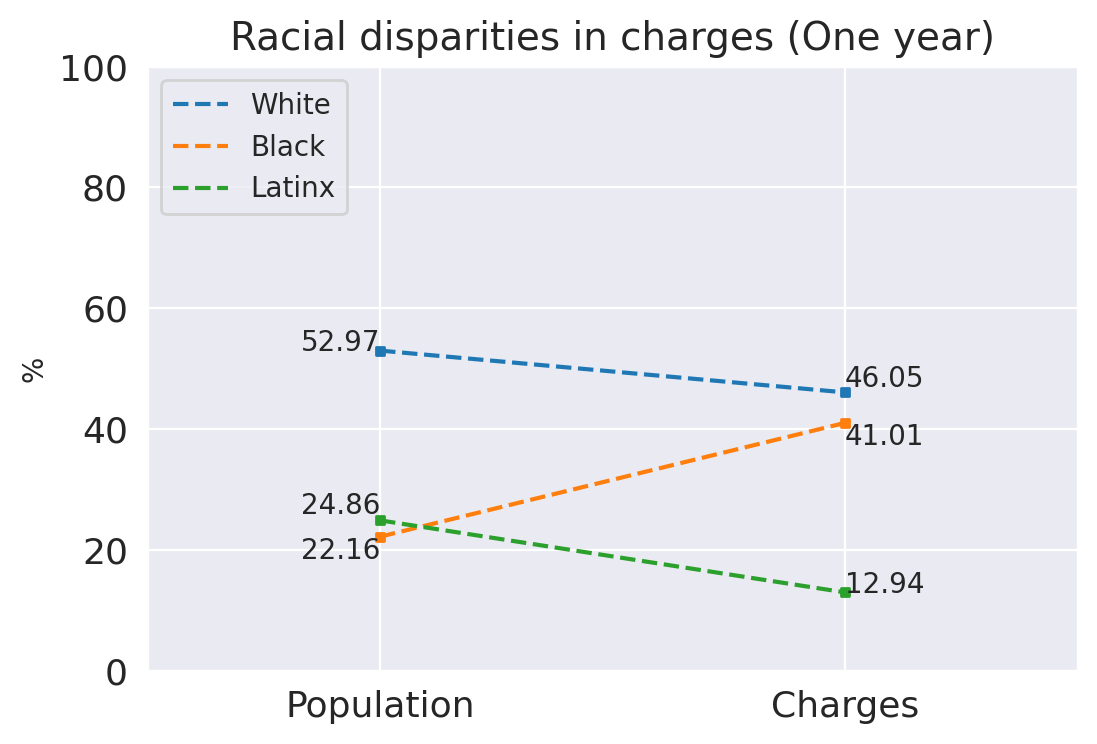

In [ ]:
def get_pop_race_pct(race, gender=NAN):

  # Gender adjust parameter accomodates unequal amouns of men and women in US
  # Source: https://data.worldbank.org/indicator/SP.POP.TOTL.FE.ZS?locations=US
  
  gender_adjust = 1
  if gender == "M":
    gender_adjust = .95
  elif gender == "F":
    gender_adjust = 1.05

  return (county_population_segments.loc[county_population_segments["Race"] == race]["Population"].sum() * gender_adjust) \
  / ((county_population_segments["Population"].sum())) * 100

def get_charge_race_pct(race):
    return records_joined_filtered.loc[records_joined_filtered["Race"] == race]["CaseNum"].count() \
  / records_joined_filtered["CaseNum"].count() * 100

def get_y(race): 
  return [get_pop_race_pct(race), get_charge_race_pct(race)]

x = ["Population", "Charges"]
w_y = get_y("W")
b_y = get_y("B")
h_y = get_y("H")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200  

plt.ylim(0, 100)

plt.scatter(x,w_y, marker='s', s=10, linewidths=True)
plt.scatter(x,b_y, marker='s', s=10, linewidths=True)
plt.scatter(x,h_y, marker='s', s=10, linewidths=True)

plt.plot(x, w_y, label="White", linestyle='dashed')
plt.plot(x, b_y, label="Black", linestyle='dashed')
plt.plot(x, h_y, label="Latinx", linestyle='dashed')

plt.margins(.5)
plt.legend(loc='upper left')

plt.ylabel("%")
plt.title("Racial disparities in charges (One year)")

plt.text(0,w_y[0], round(w_y[0],2), horizontalalignment='right')
plt.text(1,w_y[1], round(w_y[1],2), horizontalalignment='left', verticalalignment="bottom")

plt.text(0,b_y[0], round(b_y[0],2), horizontalalignment='right', verticalalignment="top")
plt.text(1,b_y[1], round(b_y[1],2), horizontalalignment='left', verticalalignment="top")

plt.text(0,h_y[0], round(h_y[0],2), horizontalalignment='right', verticalalignment="bottom")
plt.text(1,h_y[1], round(h_y[1],2))


plt.show()

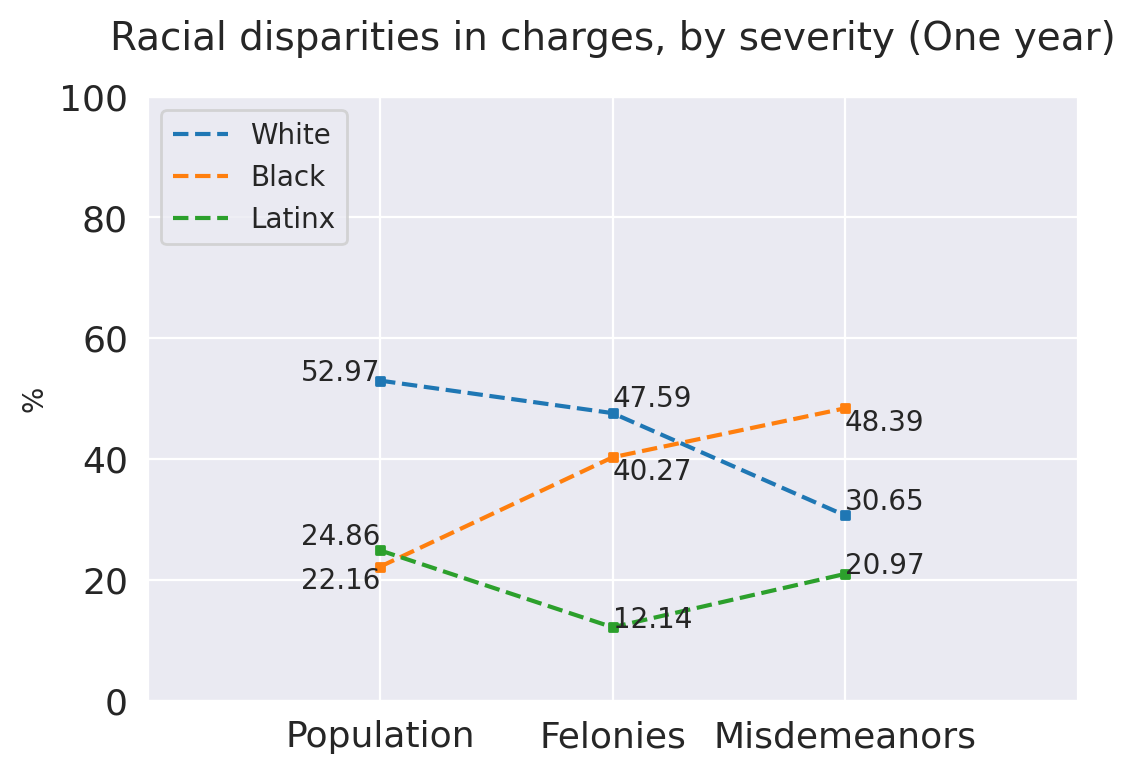

In [ ]:
# Exploring the raw data to see if it conforms to our expectation
def get_felony_charge_race_pct(race):
    return records_joined_filtered.loc[(records_joined_filtered["Race"] == race) & (records_joined_filtered["Severity"] == "F")]["CaseNum"].count() \
  / records_joined_filtered.loc[records_joined_filtered["Severity"] == "F"]["CaseNum"].count() * 100

def get_misdemeanor_charge_race_pct(race):
    return records_joined_filtered.loc[(records_joined_filtered["Race"] == race) & (records_joined_filtered["Severity"] == "M")]["CaseNum"].count() \
  / records_joined_filtered.loc[records_joined_filtered["Severity"] == "M"]["CaseNum"].count() * 100

def get_y(race): 
  return [get_pop_race_pct(race), get_felony_charge_race_pct(race), get_misdemeanor_charge_race_pct(race)]

x = ["Population", "Felonies", "Misdemeanors"]
w_y = get_y("W")
b_y = get_y("B")
h_y = get_y("H")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200  

plt.ylim(0, 100)

plt.scatter(x,w_y, marker='s', s=10, linewidths=True)
plt.scatter(x,b_y, marker='s', s=10, linewidths=True)
plt.scatter(x,h_y, marker='s', s=10, linewidths=True)

plt.plot(x, w_y, label="White", linestyle='dashed')
plt.plot(x, b_y, label="Black", linestyle='dashed')
plt.plot(x, h_y, label="Latinx", linestyle='dashed')

plt.margins(.5, tight=False)
plt.legend(loc='upper left')
# plt.padding(left=0.5, right=0.5)


plt.ylabel("%")
plt.title("Racial disparities in charges, by severity (One year)", y=1.05)

plt.text(0,w_y[0], round(w_y[0],2), horizontalalignment='right')
plt.text(1,w_y[1], round(w_y[1],2), horizontalalignment='left', verticalalignment="bottom")
plt.text(2,w_y[2], round(w_y[2],2), horizontalalignment='left', verticalalignment="bottom")

plt.text(0,b_y[0], round(b_y[0],2), horizontalalignment='right', verticalalignment="top")
plt.text(1,b_y[1], round(b_y[1],2), horizontalalignment='left', verticalalignment="top")
plt.text(2,b_y[2], round(b_y[2],2), horizontalalignment='left', verticalalignment="top")

plt.text(0,h_y[0], round(h_y[0],2), horizontalalignment='right', verticalalignment="bottom")
plt.text(1,h_y[1], round(h_y[1],2))
plt.text(2,h_y[2], round(h_y[2],2))

plt.show()

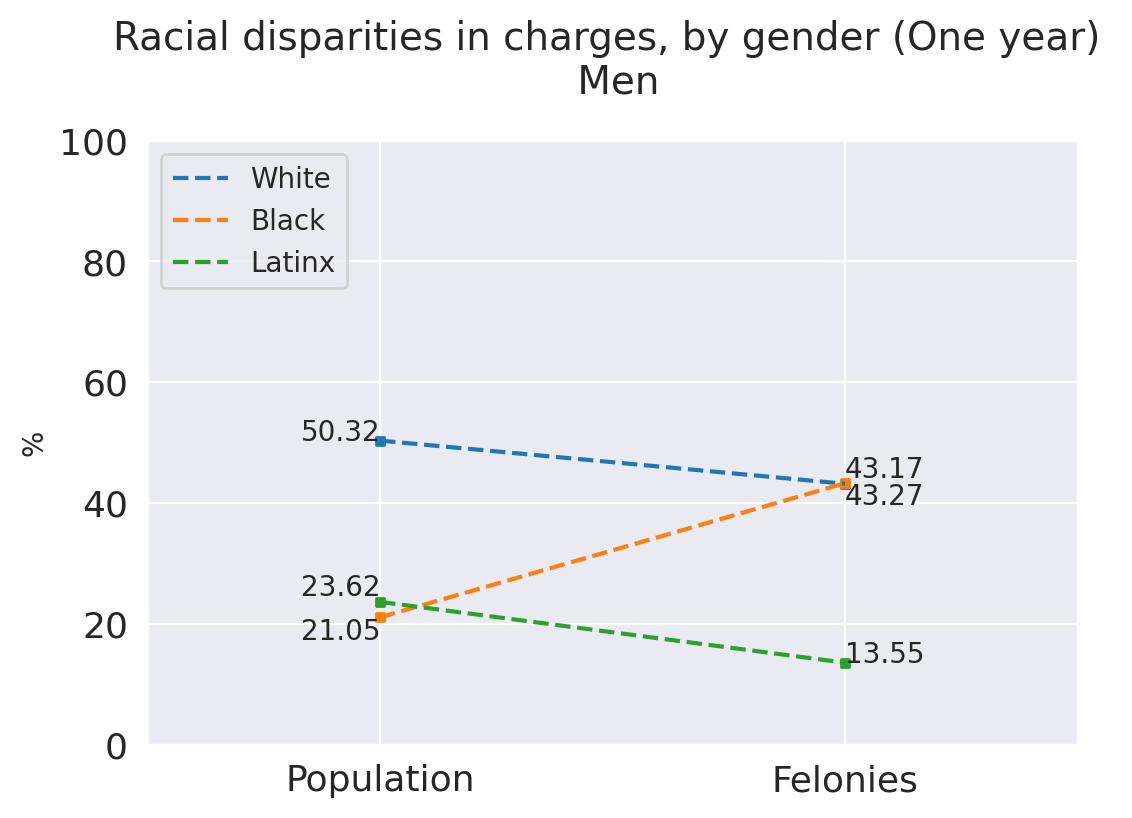

In [ ]:
def get_records_by_gender(gender):
  return records_joined_filtered.loc[records_joined_filtered["Gender"] == gender]

def get_felony_charge_race_pct(race, records):
    return records.loc[(records["Race"] == race) & (records["Severity"] == "F")]["CaseNum"].count() \
  / records.loc[records["Severity"] == "F"]["CaseNum"].count() * 100

def get_misdemeanor_charge_race_pct(race, records):
    return records.loc[(records["Race"] == race) & (records["Severity"] == "M")]["CaseNum"].count() \
  / records.loc[records["Severity"] == "M"]["CaseNum"].count() * 100

men = get_records_by_gender("M")

def get_y(race): 
  return [get_pop_race_pct(race, gender = "M"), get_felony_charge_race_pct(race, men)]

x = ["Population", "Felonies"]
w_y = get_y("W")
b_y = get_y("B")
h_y = get_y("H")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200  

plt.ylim(0, 100)

plt.scatter(x,w_y, marker='s', s=10, linewidths=True)
plt.scatter(x,b_y, marker='s', s=10, linewidths=True)
plt.scatter(x,h_y, marker='s', s=10, linewidths=True)

plt.plot(x, w_y, label="White", linestyle='dashed')
plt.plot(x, b_y, label="Black", linestyle='dashed')
plt.plot(x, h_y, label="Latinx", linestyle='dashed')

plt.margins(.5, tight=False)
plt.legend(loc='upper left')
# plt.padding(left=0.5, right=0.5)


plt.ylabel("%")
plt.title("Racial disparities in charges, by gender (One year) \n Men", y=1.05)
# plt.subtitle("Men", y=1.05)
# plt.suptitle("Men", y=.95)


plt.text(0,w_y[0], round(w_y[0],2), horizontalalignment='right')
plt.text(1,w_y[1], round(w_y[1],2), horizontalalignment='left', verticalalignment="bottom")

plt.text(0,b_y[0], round(b_y[0],2), horizontalalignment='right', verticalalignment="top")
plt.text(1,b_y[1], round(b_y[1],2), horizontalalignment='left', verticalalignment="top")

plt.text(0,h_y[0], round(h_y[0],2), horizontalalignment='right', verticalalignment="bottom")
plt.text(1,h_y[1], round(h_y[1],2))

plt.show()

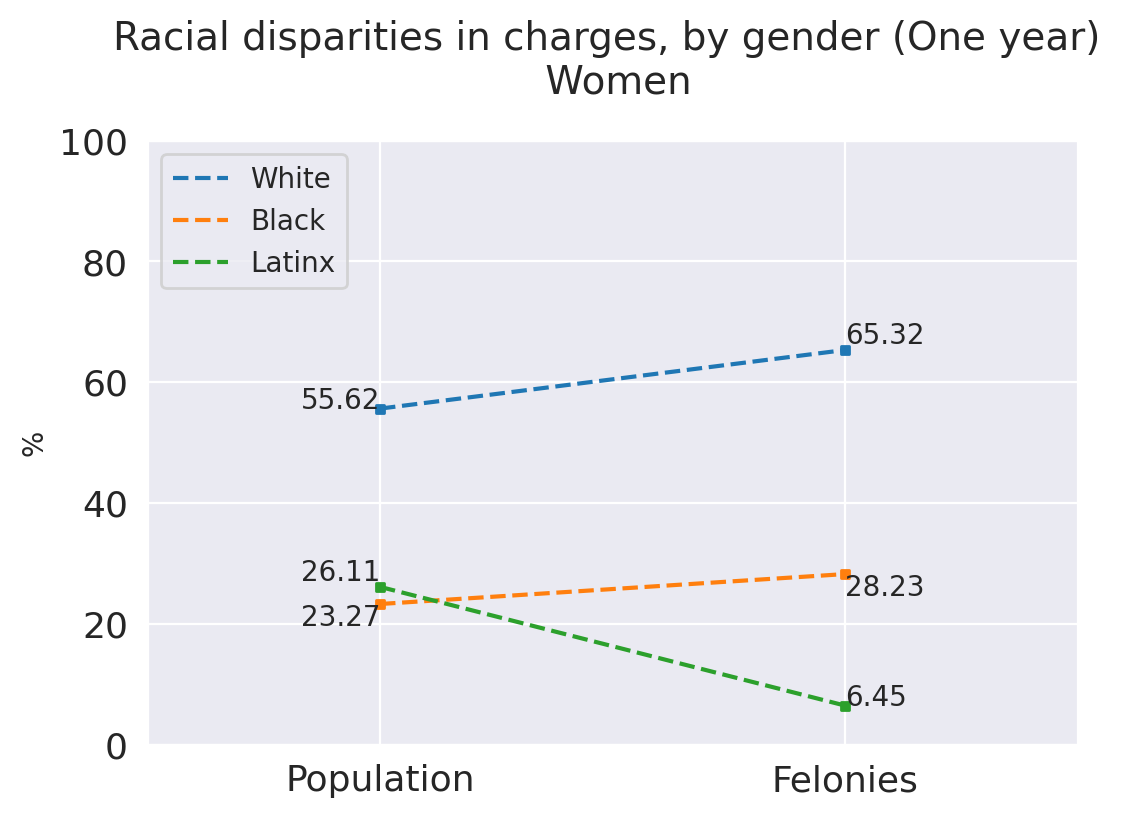

In [ ]:
# Plot breakdowns for women
women = get_records_by_gender("F")

def get_y(race): 
  return [get_pop_race_pct(race, gender = "F"), get_felony_charge_race_pct(race, women)]

x = ["Population", "Felonies"]
w_y = get_y("W")
b_y = get_y("B")
h_y = get_y("H")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200  

plt.ylim(0, 100)

plt.scatter(x,w_y, marker='s', s=10, linewidths=True)
plt.scatter(x,b_y, marker='s', s=10, linewidths=True)
plt.scatter(x,h_y, marker='s', s=10, linewidths=True)

plt.plot(x, w_y, label="White", linestyle='dashed')
plt.plot(x, b_y, label="Black", linestyle='dashed')
plt.plot(x, h_y, label="Latinx", linestyle='dashed')

plt.margins(.5, tight=False)
plt.legend(loc='upper left')
# plt.padding(left=0.5, right=0.5)


plt.ylabel("%")
plt.title("Racial disparities in charges, by gender (One year) \n Women", y=1.05)
# plt.subtitle("Men", y=1.05)
# plt.suptitle("Men", y=.95)


plt.text(0,w_y[0], round(w_y[0],2), horizontalalignment='right')
plt.text(1,w_y[1], round(w_y[1],2), horizontalalignment='left', verticalalignment="bottom")
# plt.text(2,w_y[2], round(w_y[2],2), horizontalalignment='left', verticalalignment="bottom")

plt.text(0,b_y[0], round(b_y[0],2), horizontalalignment='right', verticalalignment="top")
plt.text(1,b_y[1], round(b_y[1],2), horizontalalignment='left', verticalalignment="top")
# plt.text(2,b_y[2], round(b_y[2],2), horizontalalignment='left', verticalalignment="top")

plt.text(0,h_y[0], round(h_y[0],2), horizontalalignment='right', verticalalignment="bottom")
plt.text(1,h_y[1], round(h_y[1],2))
# plt.text(2,h_y[2], round(h_y[2],2))

plt.show()